In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
from entlearn.models.EON import EON
from entlearn.models.eSPA import eSPA
from entlearn.utils.synthetic_data import make_worm
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from tabpfn import TabPFNClassifier

np.random.seed(42)

# Extremely small data
In this example, we compare a pool of ML models on an extremely small dataset.
The data points used for training are only 30.

In [2]:
T = 300
D = 100

X, y = make_worm(D, T, 8)

inner_cv = StratifiedShuffleSplit(n_splits=1, random_state=42, train_size=30)
outer_cv = StratifiedShuffleSplit(n_splits=10, train_size=215)

In [3]:
names = [
    "Nearest Neighbors",
    "SVM",
    "Random Forest",
    "Neural Net",
    "Gradient Boosting",
    "TabPFN",
    "eSPA+",
    "EON"
]

classifiers = [
    {
        "estimator": KNeighborsClassifier(),
        "param_grid":{
            "n_neighbors": [2, 3, 5, 10, 20],
            "weights": ["uniform", "distance"],
            "metric": ["minkowski", "manhattan", "cosine", "chebyshev"],
            "p": [1, 2], 
        },
    },
    {
        "estimator": SVC(random_state=42, probability=True),
        "param_grid": {
                "kernel": ["rbf"],
                "C": [0.1, 1, 10, 100],
                "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
            },
    },
    {
        "estimator": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [10, 50, 100],
            "max_depth": [5, 10, 20, None,],  
            "max_features": ["sqrt", "log2", ],
            'min_samples_split': [2, 5],
        },
    },
    {
        "estimator": MLPClassifier(
            max_iter=2000, random_state=42, early_stopping=True, n_iter_no_change=10
        ),
        "param_grid": {
            'solver': ['adam'],
            'hidden_layer_sizes': [(50,), (100,), (150,), (250,), (50, 50, ), (100, 50, ), (150, 100, ), (250, 150, ),],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001],
            'learning_rate_init': [0.001, 0.01],
        },
    },
    {
        "estimator": GradientBoostingClassifier(
            n_estimators=500,
            random_state=42,
            n_iter_no_change=10, 
            validation_fraction=0.1,
        ),
        "param_grid": {
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 8],
            'subsample': [0.7, 0.9, 1.0], 
            'max_features': ['sqrt', 'log2'],
            'min_samples_leaf': [1, 5, 10],
        },
    },
    {
        "estimator": TabPFNClassifier(),
        "param_grid": {
            "n_estimators": [4,8]
        },
    },
    {
        "estimator": eSPA(anneals=10),
        "param_grid": {
            "epsC" : [1e-2, 5e-2, 1e-1],
            "epsW" : [1e-3, 1e-2, 5e-2, 1e-1],
            "K" : [3, 9, 12],
        },
    },
    {
        "estimator": EON(anneals=10),
        "param_grid": {
            "epsC" : [1e-2, 5e-2, 1e-1],
            "epsD" : [1e-3, 1e-2, 5e-2, 1e-1],
            "epsG" : [1e-3, 1e-2, 5e-2, 1e-1],
            "epsT" : [1e-3, 1e-2, 5e-2, 1e-1],
            "K": [3, 6, 9],
        }
    },
]

Cross-validation 1/10 for Nearest Neighbors
Nearest Neighbors - Train score 0.58, Test score: 0.56
Cross-validation 2/10 for Nearest Neighbors
Nearest Neighbors - Train score 1.00, Test score: 0.54
Cross-validation 3/10 for Nearest Neighbors
Nearest Neighbors - Train score 0.69, Test score: 0.53
Cross-validation 4/10 for Nearest Neighbors
Nearest Neighbors - Train score 0.63, Test score: 0.56
Cross-validation 5/10 for Nearest Neighbors
Nearest Neighbors - Train score 0.44, Test score: 0.42
Cross-validation 6/10 for Nearest Neighbors
Nearest Neighbors - Train score 1.00, Test score: 0.58
Cross-validation 7/10 for Nearest Neighbors
Nearest Neighbors - Train score 0.39, Test score: 0.45
Cross-validation 8/10 for Nearest Neighbors
Nearest Neighbors - Train score 0.90, Test score: 0.49
Cross-validation 9/10 for Nearest Neighbors
Nearest Neighbors - Train score 1.00, Test score: 0.53
Cross-validation 10/10 for Nearest Neighbors
Nearest Neighbors - Train score 1.00, Test score: 0.61
Cross-val

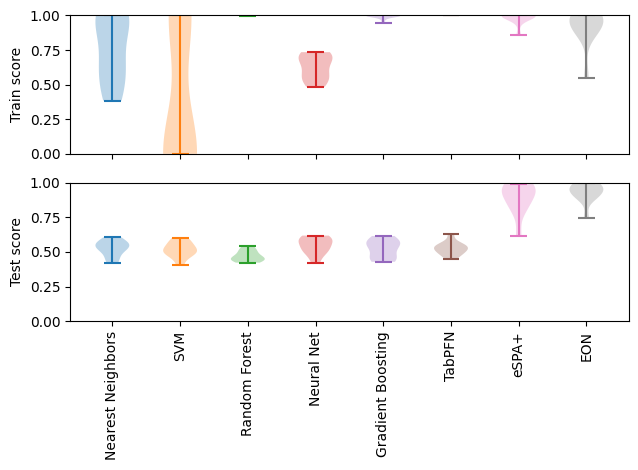

In [4]:
fig, axs = plt.subplots(2,1,sharex=True)

# For each classifier, perform cross-validation
for i, (name, clf) in enumerate(zip(names, classifiers)):

    # Initialize arrays to store scores
    test_scores = np.zeros(outer_cv.get_n_splits())
    train_scores = np.zeros(outer_cv.get_n_splits())

    # Perform crossvalidation using the split objects. It must be done manually (without cross_validate) to avoid refitting.
    for i_cv, (train_val_index, test_index) in enumerate(outer_cv.split(X, y)):

        # Separate test set from the training/validation set
        X_train_val, X_test = X[train_val_index], X[test_index]
        y_train_val, y_test = y[train_val_index], y[test_index]
        
        # Separate inner cross-validation indices
        train_index, val_index = next(inner_cv.split(X_train_val, y_train_val))
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        # Generate grid of hyperparameter combinations
        param_names, param_values = zip(*clf["param_grid"].items())
        hyperparam_combinations = [dict(zip(param_names, v)) for v in itertools.product(*param_values)]

        best_val_score = -np.inf
        best_fit_time = np.inf
        best_model = None
        for combination in hyperparam_combinations:
            est = clone(clf["estimator"])
            est.set_params(**combination)

            est.fit(X_train,y_train)

            # validation score
            val_score = roc_auc_score(y_val, est.predict_proba(X_val)[:,1])

            if val_score > best_val_score:
                best_val_score = val_score
                best_model = est        
        
        # Compute training and test scores
        train_scores[i_cv] = roc_auc_score(y_train_val[train_index], best_model.predict_proba(X_train_val[train_index])[:,1])
        
        # Calculare roc_auc score on the test set
        best_model.predict_proba(X_test)
        test_scores[i_cv] = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

        print(f"Cross-validation {i_cv+1}/{outer_cv.get_n_splits()} for {name}")
        print(f"{name} - Train score {train_scores[i_cv]:.2f}, Test score: {test_scores[i_cv]:.2f}")
        
    # Plot the results
    axs[0].violinplot(train_scores, [i])
    axs[1].violinplot(test_scores, [i])

axs[0].set_ylabel("Train score")
axs[0].set_ylim(0, 1)
axs[1].set_ylabel("Test score")
axs[1].set_ylim(0, 1)
axs[1].set_xticks(range(len(names)), labels=names, rotation="vertical")

plt.tight_layout()
plt.show()